# Adversarial Attacks



## Preparation

In [106]:
import torch
import torchvision
from torchvision.transforms import v2

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, './util')
import vcpi_util

### Model definition

In [107]:
class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x) # -> (bs, 32, 14, 14)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, num_classes)

        return(x)
    

def plot_predictions(img, models, correct):

    fig, axes = plt.subplots(nrows=1, ncols=len(models), sharey=True, figsize = (20, 2))

    for i, ax in enumerate(axes.ravel()):

        output = models[i].forward(img)
        output_probs = torch.nn.functional.softmax(output, dim=-1).cpu().detach().numpy().squeeze(0)
        pred = np.argmax(output_probs, axis=-1)
        colors = ["#777777" for i in range(10)]
        colors[pred] = 'red'
        colors[correct] = 'blue'
        ax.set_title(f'Model {i}')
        ax.bar(range(8), output_probs, color=colors)
        ax.set_ylim([0, 1])
        ax.set_xticks(range(8))


def plot_adversarial(original, perturbation, adversarial):

    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize = (15,5))

    ax = axes.ravel()

    ax[0].set_title(f'Original')
    ax[0].imshow(np.transpose(original.cpu().detach().numpy().squeeze(0), (1,2,0))) 
    ax[0].axis('off')     

    ax[1].set_title(f'Perturbation')
    ax[1].imshow(np.transpose(perturbation.cpu().detach().numpy().squeeze(0), (1,2,0))) 
    ax[1].axis('off')   

    ax[2].set_title(f'Adversarial')
    ax[2].imshow(np.transpose(adversarial.cpu().detach().numpy().squeeze(0), (1,2,0))) 
    ax[2].axis('off')           

In [108]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [109]:
PATH_TEST_SET = '../AULA 8/gtsrb_datasets/test'

transform = v2.Compose(
    [v2.Resize((32,32)), 
     v2.ToImage(), 
     v2.ToDtype(torch.float32, scale=True)]) 

# No shuffle is required for the test set, also the batch size can be completely different
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128)

### Load models trained on GTSRB

In [110]:

models = []
acc = []

for i in range(10):

    reload = torch.load(f'./modelos/aug_II_{i}_best.pt')
    model = Conv(8)
    model.load_state_dict(reload['model'])
    model.to(device)
    models.append(model)
    

In [111]:
torchinfo.summary(models[0], input_size=(32,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [32, 16, 30, 30]          32
├─ReLU: 1-3                              [32, 16, 30, 30]          --
├─Conv2d: 1-4                            [32, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 28, 28]          64
├─ReLU: 1-6                              [32, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [32, 32, 14, 14]          --
├─Conv2d: 1-8                            [32, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [32, 48, 12, 12]          96
├─ReLU: 1-10                             [32, 48, 12, 12]          --
├─Conv2d: 1-11                           [32, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [32, 48, 10, 10]          96
├─R

In [112]:
img = Image.open("../AULA 8/gtsrb_datasets/test/00001/s00024.png")
img_tensor = transform(img)

In [113]:
img_tensor = img_tensor.unsqueeze(0)
img_var = torch.autograd.Variable(img_tensor,requires_grad= True).to(device)

class_id = 1

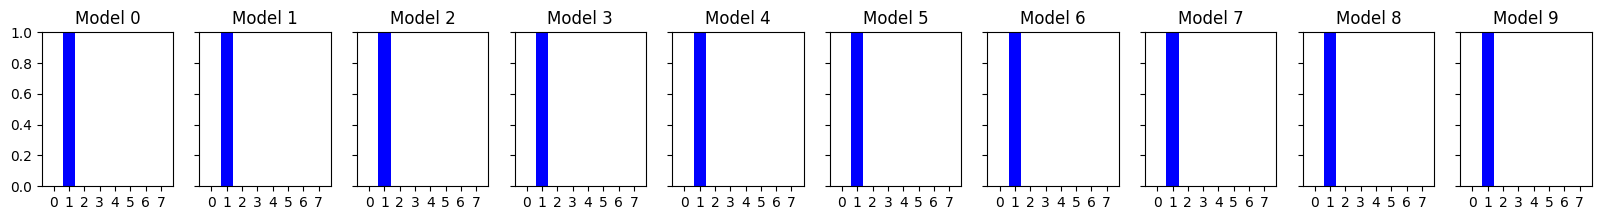

In [114]:
plot_predictions(img_var,models,class_id)

In [115]:
img_var.retain_grad()

loss_fn = torch.nn.CrossEntropyLoss()
output = models[0].forward(img_var)
target = torch.LongTensor([class_id])

loss = loss_fn(output, target.to(device))
loss.backward(retain_graph=True)

In [116]:
epsilon = 0.1
grad_sign = torch.sign(img_var.grad.data)
perturbation = grad_sign*epsilon
adversarial = img_var+perturbation

In [117]:
adversarial_clamped = adversarial.clamp(0,1)

In [118]:
output - models[0].forward(adversarial_clamped)
out_probs = torch.nn.functional.softmax(output[0],-1)
print(out_probs.cpu().detach().numpy())

[2.8809097e-10 9.9999809e-01 9.1075378e-08 3.1127909e-10 4.8643159e-08
 1.8445069e-06 3.8215825e-10 3.4798092e-10]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


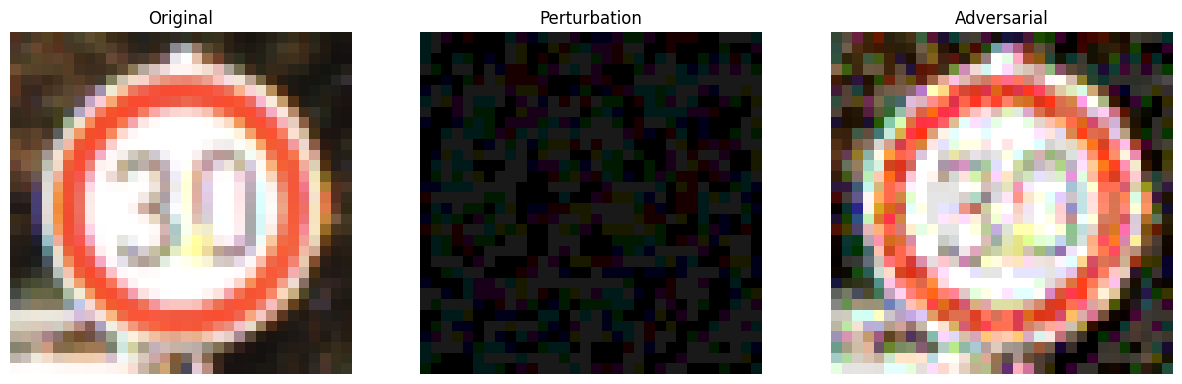

In [119]:
plot_adversarial(img_var, perturbation, adversarial_clamped)

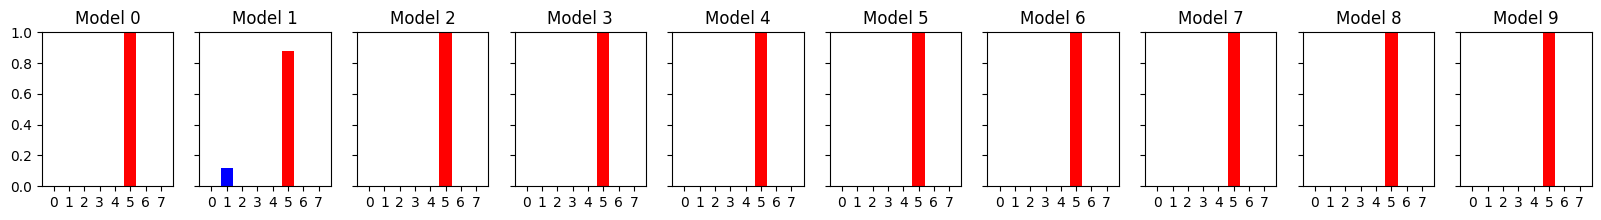

In [120]:
plot_predictions(adversarial_clamped,models,class_id)

In [130]:
# ataque direcionado
target_class = 6
target = torch.LongTensor([target_class])

output = models[0].forward(img_var)
loss = loss_fn(output, target.to(device))

loss.backward(retain_graph=True)

epsilon = 0.15
grad_sign = torch.sign(img_var.grad.data)
perturbation = grad_sign * epsilon
adversarial = (
    img_var - perturbation
)  # a diferença entre o ataque direcionado e não direcionado é o + e o -



In [131]:
adversarial_clamped = adversarial.clamp(0,1)
output = models[0].forward(adversarial_clamped)
print(output)

tensor([[-12.5056,  -8.1156, -11.6754, -15.1646,  -8.6580,  -7.0996,   6.2528,
          -3.3978]], device='cuda:0', grad_fn=<AddmmBackward0>)


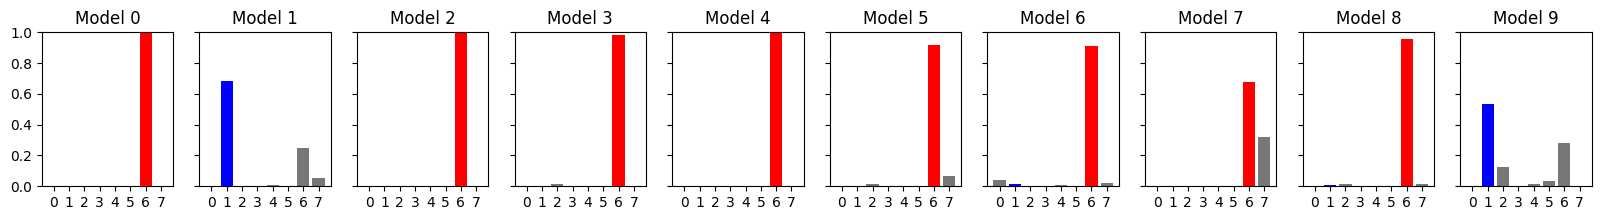

In [132]:
plot_predictions(adversarial_clamped,models,1)

tensor([4], device='cuda:0') tensor([1], device='cuda:0') tensor(13.3757, device='cuda:0', grad_fn=<NllLossBackward0>)


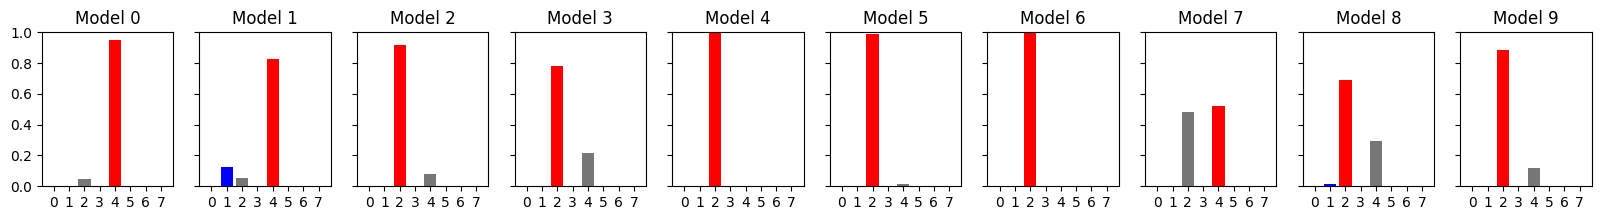

In [139]:
epsilon = 0.1
alpha = 10
label = torch.LongTensor([class_id]).to(device)

perturbation = torch.zeros_like(img_var)
i = 0
not_succeeded = True

while i < 100 and not_succeeded:
    img_var.retain_grad()
    output = models[0].forward(img_var)
    loss = loss_fn(output, label)

    _,pred = torch.max(output, -1)
    print(pred, label, loss)
    if (pred != label):
        not_succeeded = False
        break

    loss.backward(retain_graph=True)
    grad_sign = torch.sign(img_var.grad.data)
    perturbation = (grad_sign * alpha).clamp(-epsilon, epsilon)
    img_var.grad.data.zero_()
    img_var = img_var + perturbation

    i += 1

plot_predictions(img_var,models,class_id)